## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


## Camera calibration (1/3)

The code below loads calibration images and shows an interactive selector to check if corners are detected.

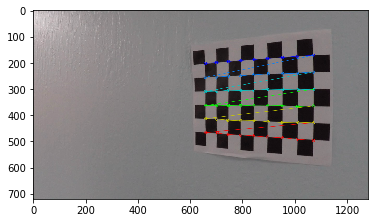

In [17]:
import numpy as np
import cv2
import glob
from ipywidgets import interactive, interact
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
(RR,CC) = (6, 9)

objp = np.zeros((RR*CC,3), np.float32)
objp[:,:2] = np.mgrid[0:CC,0:RR].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
def view_corners(fname):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (CC,RR),None)

    # If found, add object points, image points
    if ret == True:
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (CC,RR), corners, ret)
    else:
        print("No corners found")
    plt.imshow(img)
    plt.show()

#cv2.destroyAllWindows()
interact(view_corners, fname=images)




## Camera calibration (2/3)

Once we've check above that corners have been detected, we can now build a list of points and detected corners which will be used in subsequent cells.

In [2]:
# Step through the list and search for chessboard corners
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (CC,RR), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        


## Camera calibration (3/3)

We compute camera calibration and visually inspect checkerboard pattern and its undistorted counterpart.

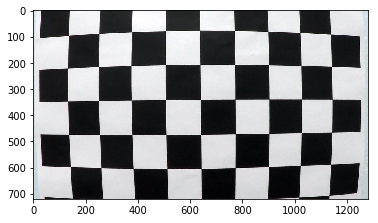

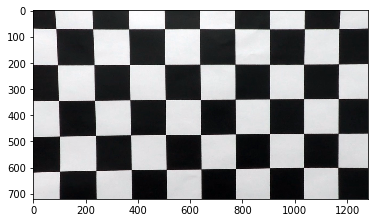

In [3]:
# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(img)
plt.show()
plt.imshow(dst)
plt.show()


## Helper functions

The cells below contain some helper functions and class which we'll use for video and image pipelines. Most functions are straight-forward. 

To determine the road plane I examined the following image and detected the vanishing point manually. The vanishing point is useful to choose the vertex of the road plane.

![](./road-plane.png)

In [24]:
# Lane is used for storing common data across functions.
# Not proper OO-design, but that's not the goal of this project either.
class Lane():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected    = False  
        self.left_curve  = None
        self.right_curve = None
        self.left_curve_coeff  = None
        self.right_curve_coeff = None
        self.M           = None
        self.Minv        = None
        
lane = Lane()

In [18]:
# given an image i return the vertex of the road plane.
def road_plane(i):
    vanishing_point = (640./1280.,427./738)
    isz = (i.shape[1], i.shape[0])
    x = np.float32([0,640])
    y = np.float32([isz[1]-1,isz[1]*vanishing_point[1]])
    p = np.poly1d(np.polyfit(x,y,1))
    n=60

    return  np.array([[640-n, p(640-n)],
                      [640+n, p(640-n)],
                      [1280,  p(0)],
                      [0,     p(0)]], dtype=np.float32)

# undistort image given camera calibration parameters
def undistort(img):
    i= cv2.undistort(img, mtx, dist, None, mtx)
    return i

# unwarp polygon of incoming image i, and store transformation matrix in 
# lane object.
def unwarp_road(i):
    isz = (i.shape[1], i.shape[0])
    
    w = isz[1]
    
    target_plane = np.array(
        [[320,   0], 
         [960,  0], 
         [960,   w], 
         [320,   w]], dtype=np.float32)
        
    lane.M    = cv2.getPerspectiveTransform(road_plane(i), target_plane)
    lane.Minv = cv2.getPerspectiveTransform(target_plane, road_plane(i))
    
    unwarp = cv2.warpPerspective(i, lane.M, (1280,w))
    
    return unwarp


In [19]:
# helper functions compute various sobel gradients 
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    grad_binary = np.zeros_like(img)
    if thresh[0] < thresh[1]:
        grad = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1 if orient =='x' else 0, 1 if orient =='y' else 0,ksize=sobel_kernel))
        grad = np.uint8(255. * grad/np.max(grad))
        grad_binary[(grad > thresh[0]) & (grad <= thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    mag_binary = np.zeros_like(img)
    if mag_thresh[0] < mag_thresh[1]:
        gx = cv2.Sobel(img, cv2.CV_64F, 1, 0 ,ksize=sobel_kernel)
        gy = cv2.Sobel(img, cv2.CV_64F, 0, 1 ,ksize=sobel_kernel)
        grad = np.sqrt(gx**2 + gy**2)
        grad = np.uint8(255. * grad/np.max(grad))
        mag_binary[(grad > mag_thresh[0]) & (grad <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)): 
    # Calculate gradient direction
    # Apply threshold
    dir_binary = np.zeros_like(img)
    if thresh[0] < thresh[1]:
        gx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0 ,ksize=sobel_kernel))
        gy = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1 ,ksize=sobel_kernel))
        grad = np.arctan2(gy,gx)
        dir_binary[(grad > thresh[0]) & (grad <= thresh[1])] = 1
    return dir_binary


## Distorsion-correction

Once we have calculated camera calibration we visually inspect a road image and its undistorted counterpart. The effects of the correction are especially easier to perceive at the corners of the image.

The next cells shows the original (distorted) image on top and the computed undistorted version below.

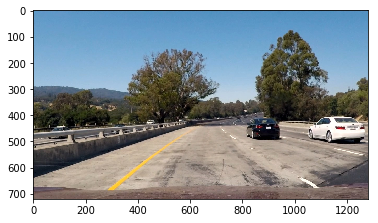

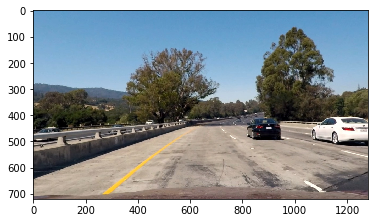

In [21]:
import matplotlib.image as mpimg

test = mpimg.imread('test_images/test1.jpg')

plt.imshow(test)
plt.show()
plt.imshow(undistort(test))
plt.show()

## Perspective-warping

The next cells shows the undistorted image on top and the perspective-warped version below. Care must be taken to use the undistorted version prior to perspective correction. The helper functions above provide the points of the road plane. 

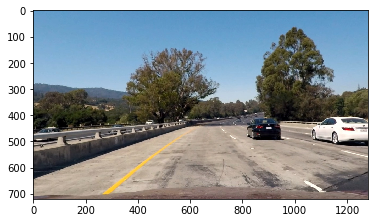

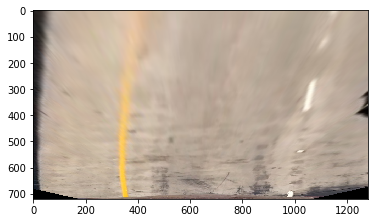

In [7]:
import matplotlib.image as mpimg

test = mpimg.imread('test_images/test1.jpg')

plt.imshow(undistort(test))
plt.show()
plt.imshow(unwarp_road(undistort(test)))
plt.show()

## Thresholding (1/2)

This is probably the most sensitive part of this project. The goal is to use gradients, color thresholding, etc. and produce a binary version of the image that shows the road lanes as clearly as possible and as less as possible (at least in the road plane).

I tried many combinations and managed to use color thresholding exclusively. The code below shows an interactive widget initialized to the values I found worked best. Note that gradient-related limits are set in a way in which they don't affect (I could have removed them altogether but decided to keep in case I wanted to tweak further).

I used the HSL colorspace. Pixels whose S value is between 90 and 255 *and* H value is between 17 and 60 are selected and work to detect the yellow lane. Pixels whose L value is between 200 and 255 *and* S value is between 10 and 255 are selected and work to detect the white lane.


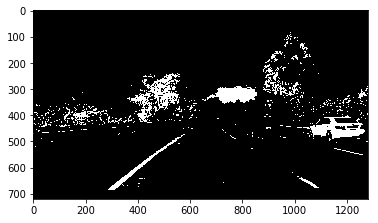

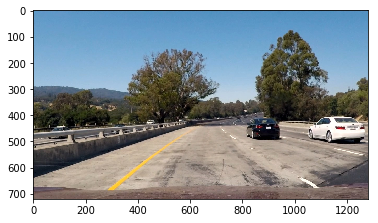

In [8]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

def threshold(image, ksize, gx_min, gx_max, gy_min, gy_max, mag_min, mag_max, dir_min, dir_max, s_min, s_max, h_min, h_max, wv_min, wv_max, ws_min, ws_max):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    lab_image = hsv_image # cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    h_image   = hsv_image[:,:,0]
    s_image   = hsv_image[:,:,2]
    v_image   = hsv_image[:,:,1]
    
    hs_binary = np.zeros_like(h_image)
    hs_binary[((s_image >  s_min) & (s_image <= s_max)  & (h_image >  h_min) & (h_image <=  h_max)) |
              ((v_image > wv_min) & (v_image <= wv_max) & (s_image > ws_min) & (s_image <= ws_max)) ] = 1    
    
    gg_image  = lab_image[:,:,2] 
    gradx = abs_sobel_thresh(gg_image, orient='x', sobel_kernel=ksize, thresh=(gx_min, gx_max))
    grady = abs_sobel_thresh(gg_image, orient='y', sobel_kernel=ksize, thresh=(gy_min, gy_max))
    mag_binary = mag_thresh(gg_image, sobel_kernel=ksize, mag_thresh=(mag_min, mag_max))
    dir_binary = dir_threshold(gg_image, sobel_kernel=ksize, thresh=(dir_min, dir_max))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))| (hs_binary == 1) ] = 255
    
    thresholded = np.empty_like(image)
    thresholded[:,:,2] = thresholded[:,:,1] = thresholded[:,:,0] = combined
    return thresholded
    
def update(fname, ksize, gx_min, gx_max, gy_min, gy_max, mag_min, mag_max, dir_min, dir_max, s_min, s_max, h_min, h_max, wv_min, wv_max, ws_min, ws_max):
    
    # Apply each of the thresholding functions
    image    = mpimg.imread(fname)
    combined = threshold(image, ksize, gx_min, gx_max, gy_min, gy_max, mag_min, mag_max, dir_min, dir_max, s_min, s_max, h_min, h_max, wv_min, wv_max, ws_min, ws_max)    
    plt.imshow(combined)
    plt.show()
    plt.imshow(image)
    plt.show()
    
w = interactive(update,
        fname = glob.glob('./test_images/test*.jpg'),
        ksize   = widgets.IntSlider(min=1,max=31,step=2, value=5),
        gx_min  = widgets.IntSlider(min=0, max=256), 
        gx_max  = widgets.IntSlider(min=0,  max=256),
        gy_min  = widgets.IntSlider(min=0, max= 256), 
        gy_max  = widgets.IntSlider(min=0,  max=256),
        mag_min = widgets.IntSlider(min=0, max=256, value=256), 
        mag_max = widgets.IntSlider(min=0, max=256, value=256),
        dir_min = widgets.FloatSlider(min=0, max=np.pi/2, value=0.40), 
        dir_max = widgets.FloatSlider(min=0, max=np.pi/2, value=1.2),
        h_min   = widgets.IntSlider(min=0, max=256, value=17),
        h_max   = widgets.IntSlider(min=0, max=256, value=60),
        s_min   = widgets.IntSlider(min=0, max=256, value=90), 
        s_max   = widgets.IntSlider(min=0, max=256, value=256),
        wv_min  = widgets.IntSlider(min=0, max=256, value=200), 
        wv_max  = widgets.IntSlider(min=0, max=256, value=256),
        ws_min  = widgets.IntSlider(min=0, max=256, value=10), 
        ws_max  = widgets.IntSlider(min=0, max=256, value=256))

display(w)

## Thresholding (2/2)

Once the parameters for thresholding has been selected, we test them again to make sure they are consistent.  


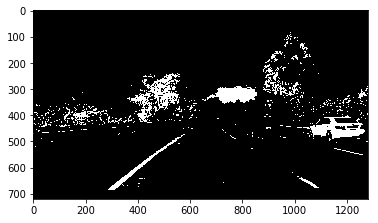

In [9]:
image    = mpimg.imread(w.kwargs['fname'])
d = dict(w.kwargs)
del d['fname']
plt.imshow(threshold(image, **d))

def threshold_x(image):
    return threshold(image, **d)


## Lane detection and fitting (1/2)

The cells below contain functions to detect lanes and fit them in second-degree polynomial. Code is properly commented within the cell. 

The code is very similar to the code provided by Udacity, the improvements are thresholding above a level to reject discontinuities in the lanes (e.g. white lane) and using a triangular-shaped window instead of a flat one to detect the exact centers of the lanes (using a flat window returned the left-sided points since the colvolded signal had many maxima-points).

In [10]:
# We will search for centroids for the left and right lanes by applying convolutions with a triangular
# window and keep the centroids above a threshold (to reject discontinuities, e.g. in the white lane).
# window settings:
window_width = 50 
window_height = 40 # Break image into 18 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching
v_threshold = 10000/window_height

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.bartlett(window_width) # bartlett is just a fancy triangular window
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    if lane.detected == False:
        # Sum quarter bottom of image to get slice, could use a different ratio
        l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    else:
        # start searching from previous frame 
        l_center = np.clip(lane.left_curve(warped.shape[0]-1),  0, warped.shape[1]-1)
        r_center = np.clip(lane.right_curve(warped.shape[0]-1), 0, warped.shape[1]-1)
    
    # Add what we found for the first layer
    #window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(0,warped.shape[0]//window_height):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_value  = np.amax(conv_signal[l_min_index:l_max_index])
        if l_value >= v_threshold:
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset

        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_value  = np.amax(conv_signal[r_min_index:r_max_index])
        if r_value >= v_threshold:
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset

        # Add what we found for that layer
        window_centroids.append((l_center,r_center, l_value, r_value, conv_signal))
        
    return window_centroids

def find_lanes(image, just_find = False):
    warped = image[:,:,0]
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    lane.detected = False
    
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 
        l_detected = []
        r_detected = []
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            if window_centroids[level][2] >= v_threshold:
                l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
                l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
                l_detected.append((image.shape[0]-((level+0.5) * window_height), window_centroids[level][0]))
            if window_centroids[level][3] >= v_threshold:
                r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
                r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
                r_detected.append((image.shape[0]-((level+0.5) * window_height), window_centroids[level][1]))

        if len(l_detected) == 0:
            l_detected.extend([[1,0], [10,0]])
        if len(r_detected) == 0:
            r_detected.extend([[1,0], [10,0]])
        lane.left_curve_coeff  = np.polyfit([i[0] for i in l_detected],[i[1] for i in l_detected],2)#,w=[i[0] for i in l_detected] )
        lane.right_curve_coeff = np.polyfit([i[0] for i in r_detected],[i[1] for i in r_detected],2)#,w=[i[0] for i in r_detected] )
        left_curve  = np.poly1d(lane.left_curve_coeff)
        right_curve = np.poly1d(lane.right_curve_coeff)
        lane.left_curve  = left_curve
        lane.right_curve = right_curve
        lane.detected = True
        if just_find == True:
            return

        # Draw the results
        for y in range(0,image.shape[0]):
            l_points[y,int( left_curve(y))-5:int( left_curve(y))+5] = 255
            r_points[y,int(right_curve(y))-5:int(right_curve(y))+5] = 255
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channle 
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 0.5, template, 1.5, 0.0) # overlay the orignal road image with window results
        
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    if just_find == True:
        return
        
    return output

## Lane detection and fitting (2/2)

The cell below shows an image along with the result of detecting lanes and fitting them with a second-order polynomial. 

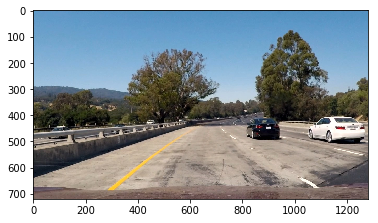

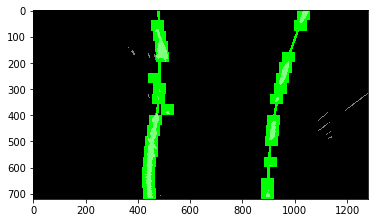

In [26]:
image    = mpimg.imread(w.kwargs['fname'])
plt.imshow(image)
plt.show()
plt.imshow(find_lanes(threshold_x(unwarp_road(undistort(image)))))
plt.show()

## Projecting lanes back

The code below plots lines back on (undistorted) image and shows the calculated radius. The radius is calculated using the code provided by Udacity. 

In [28]:
def project_lanes(image):
    # Create an image to draw the lines on
    if lane.detected:
        color_warp = np.zeros_like(image).astype(np.uint8)
        #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        left_fitx  = np.empty([image.shape[0]])
        right_fitx = np.empty([image.shape[0]])
        ploty      = np.empty([image.shape[0]])
        for i in range(0, image.shape[0]):
            ploty[i] = i
            left_fitx[i]  = lane.left_curve(i)
            right_fitx[i] = lane.right_curve(i)

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp,np.int32([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, lane.Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        rad = calc_radius(image.shape[0]-1)
        cv2.putText(result, "{:6.1f} m".format(rad), (10,60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255))
    else:
        result = image
    return result

In [12]:
def calc_radius(y_eval):

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = lane.left_curve_coeff 
    right_fit_cr = lane.right_curve_coeff 
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return (left_curverad + right_curverad)/2

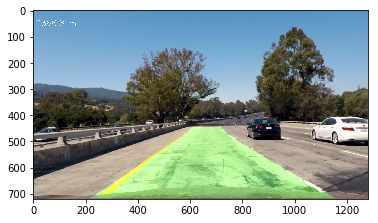

Radius: 2368.78907492 m


In [31]:
image    = mpimg.imread(w.kwargs['fname'])
plt.imshow(project_lanes((undistort(image))))
plt.show()
print ("Radius:", calc_radius(image.shape[0]-1), "m")

## Video pipeline

The cell below shows the above functions re-used for the video pipeline using CompositeVideoClip.

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip, CompositeVideoClip
from IPython.display import HTML

output = './project_video_out.mp4'
clip = VideoFileClip("./project_video.mp4")#.subclip(22,22.1)
undistorted = clip.fl_image(undistort) 
thresholded = undistorted.fl_image(threshold_x)
unwarped    = thresholded.fl_image(unwarp_road)
lanes       = unwarped.fl_image(find_lanes)
projected   = undistorted.fl_image(project_lanes)
combo = CompositeVideoClip(
    [projected, thresholded.resize(0.3).set_pos((502, 10)), lanes.resize(0.3).set_pos((886, 10))])
%time combo.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./project_video_out.mp4
[MoviePy] Writing video ./project_video_out.mp4


100%|█████████▉| 1260/1261 [12:16<00:00,  2.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out.mp4 

CPU times: user 11min 38s, sys: 1min 39s, total: 13min 17s
Wall time: 12min 18s


In [15]:
HTML("""
<video width="640" controls>
  <source src="{0}">
</video>"
""".format(output))

## Problems 

I tested the existing pipeline in the challenge video and it didn't work correctly. The reason is the thresholding is not robust enough and I should have used sobel gradients to be more immune to shadows and levels and keep lines regardless of relative thresholds of color.

Also, the road plane unwarping assumes the vanishing point is constant and that the road plane is flat, which is not the case. Even in the provided videos 